# Dataset to Sequence

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [6]:
import tensorflow as tf

# Check if TensorFlow detects GPU
print("Is TensorFlow using GPU?", tf.config.list_physical_devices('GPU'))


Is TensorFlow using GPU? []


In [7]:
df = pd.read_csv('filtered.csv')

In [8]:
df.head()

,Unnamed: 0,Sport_-1,drug_1896,equity_1896,drug_1900,equity_1900,drug_1904,equity_1904,drug_1906,equity_1906,...,CV_1980,CV_1984,CV_1988,CV_1992,CV_1996,CV_2000,CV_2004,CV_2008,CV_2012,CV_2016
0,0,Alpine Skiing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.941454,0.810152,0.975410,1.038671,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,Alpinism,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,Archery,0.0,NaN,NaN,0.0,NaN,0.228571,NaN,NaN,...,0.518674,0.486000,0.736622,0.877037,0.872777,0.840279,0.893923,0.819216,0.751548,0.849326
3,3,Art Competitions,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,Athletics,0.0,0.0,NaN,0.0,NaN,0.000000,NaN,0.0,...,1.012697,1.053289,1.032190,0.986700,1.016212,0.982383,0.984688,1.058562,0.964608,0.974802


In [9]:
data_dict = {}

for sport in df['Sport_-1'].unique():
    sport_data = df[df['Sport_-1'] == sport]
    sport_dict = {}

    for variable in ['drug', 'equity', 'popularity', 'normalized_country', 'CV']:
        # Filter the columns that belong to the current variable
        variable_cols = [col for col in df.columns if col.startswith(variable)]

        # Create a DataFrame with years and the corresponding values for this variable
        year_variable_df = sport_data[variable_cols].melt(var_name='Year_Var', value_name=variable)

        # Extract the year from the column names
        year_variable_df['Year'] = year_variable_df['Year_Var'].str.extract('(\d{4})').astype(int)
        year_variable_df = year_variable_df[['Year', variable]].dropna()

        # Add this DataFrame to the sport's dictionary
        sport_dict[variable] = year_variable_df.reset_index(drop=True)

    # Add the sport's dictionary to the main dictionary
    data_dict[sport] = sport_dict

<>:15: SyntaxWarning: invalid escape sequence '\d'
<>:15: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_31941/280139684.py:15: SyntaxWarning: invalid escape sequence '\d'
  year_variable_df['Year'] = year_variable_df['Year_Var'].str.extract('(\d{4})').astype(int)


DIctionary is in the structure of,

    "Alpine Skiing": {
        "drug":       # DataFrame for the 'drug' variable
                    Year    drug
                    1896    0.0
                    1900    NaN
                    1904    NaN
                    ...
        "equity":    # DataFrame for the 'equity' variable
                    Year    equity
                    1896    NaN
                    1900    NaN
                    1904    NaN
                    ...
        "popularity": # DataFrame for the 'popularity' variable
                    Year    popularity
                    1896    NaN
                    1900    NaN
                    1904    NaN
                    ...
        "normalized_country": # DataFrame for 'normalized_country' variable
                    Year    normalized_country
                    1896    NaN
                    1900    NaN
                    1904    NaN
                    ...
        "CV":        # DataFrame for 'CV' variable
                    Year    CV
                    1980    0.94154
                    1984    0.810152
                    1988    0.975410
                    ...
    },


    # Similar structure for other sports



In [10]:
df_Athletes_CV = data_dict['Athletics']['CV']
df_Athletes_CV.head()

,Year,CV
0,1896,1.001050
1,1900,0.975667
2,1904,0.978102
3,1906,0.892952
4,1908,1.032252


# Processing Data

In [11]:
print("Number of missing values in 'CV':", df_Athletes_CV['CV'].isnull().sum())


Number of missing values in 'CV': 0


In [12]:
df_Athletes_CV['CV'] = df_Athletes_CV['CV'].interpolate(method='linear')


In [13]:
df_Athletes_CV = df_Athletes_CV.sort_values('Year').reset_index(drop=True)


In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_Athletes_CV['CV_scaled'] = scaler.fit_transform(df_Athletes_CV['CV'].values.reshape(-1, 1))


In [15]:
#creating lstm input
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)


In [16]:
window_size = 3  # You can adjust this value
data = df_Athletes_CV['CV_scaled'].values
X, y = create_sequences(data, window_size)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)


In [18]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [19]:
X_test

array([[[0.44792083],
        [0.38897715],
        [0.26189651]],

       [[0.38897715],
        [0.26189651],
        [0.34434052]],

       [[0.26189651],
        [0.34434052],
        [0.24983563]],

       [[0.34434052],
        [0.24983563],
        [0.25627456]],

       [[0.24983563],
        [0.25627456],
        [0.46265091]],

       [[0.25627456],
        [0.46265091],
        [0.20017976]]])

# define visualization function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

def plot_training_history(history, metrics=('mse', 'r2_keras')):
    """
    Plot training and validation metrics over epochs.

    Args:
        history: Keras History object after model training.
        metrics: Tuple of metrics to plot. Default is ('mse', 'r2_keras').
    """
    plt.figure(figsize=(12, 4))

    # Plot each metric
    for i, metric in enumerate(metrics):
        plt.subplot(1, len(metrics), i + 1)
        plt.plot(history.history[metric], label=f'Training {metric.upper()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.upper()}')
        plt.title(f'{metric.upper()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.upper())
        plt.legend()

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on test data and compute MSE and R².

    Args:
        model: Trained model to evaluate.
        X_test: Test input data.
        y_test: Test target data.

    Returns:
        test_mse: Mean Squared Error on the test set.
        test_r2: R² score on the test set.
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Reshape y_test if necessary
    if y_test.ndim > 1:
        y_test = y_test.reshape(-1)

    # Compute metrics
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)

    print(f"Test MSE: {test_mse}")
    print(f"Test R²: {test_r2}")

    return test_mse, test_r2

def plot_predictions(model, data, window_size, scaler, years, target_column='CV_scaled', title='Actual vs Predicted CV Values Over Years'):
    """
    Plot actual vs predicted values for a given model.

    Args:
        model: Trained model for prediction.
        data: DataFrame or array containing the input data.
        window_size: Size of the sequence window used during training.
        scaler: Scaler object used for scaling the data.
        years: Array of years corresponding to the data.
        target_column: Column name of the scaled target variable in `data`.
        title: Title for the plot.
    """
    # Extract the target column as a NumPy array
    data_values = data[target_column].values

    # Create sequences
    X_all, y_all = create_sequences(data_values, window_size)

    # Reshape for LSTM input
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))

    # Make predictions
    y_pred_scaled = model.predict(X_all)

    # Inverse transform predictions and actual values
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_actual = scaler.inverse_transform(y_all.reshape(-1, 1))

    # Adjust years to match the prediction length
    adjusted_years = years[window_size:]

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(adjusted_years, y_actual, label='Actual', marker='o')
    plt.plot(adjusted_years, y_pred, label='Predicted', marker='x')
    plt.xlabel('Year')
    plt.ylabel('CV')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Attempt 5: LSTM + ARIMA (Hybrid Model), not that actually bad though



In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = data_dict['Athletics']['CV']
df.head()

,Year,CV
0,1896,1.001050
1,1900,0.975667
2,1904,0.978102
3,1906,0.892952
4,1908,1.032252


In [ ]:
time_series_data = df['CV']

In [ ]:
!pip install pmdarima


In [ ]:
import pmdarima as pm

# Perform grid search for optimal ARIMA order
model = pm.auto_arima(
    time_series_data,
    start_p=0, max_p=5,      # Range for p
    start_q=0, max_q=5,      # Range for q
    d=None,                  # Automatically determine d
    start_d=0, max_d=2,      # Differencing range
    seasonal=False,          # Use seasonal=True for SARIMA
    trace=True,              # Print search progress
    error_action='ignore',   # Ignore errors during search
    suppress_warnings=True,  # Suppress warnings
    stepwise=True            # Use stepwise algorithm for efficiency
)

# Display the best model summary
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=87.167, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-54.302, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-53.264, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-61.894, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-63.547, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-59.452, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-61.578, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-63.880, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-61.884, Time=0.17 sec
 ARIMA(

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Extract the best order
best_order = model.order  # (p, d, q)

# Fit ARIMA with the optimal order
arima_model = ARIMA(time_series_data, order=best_order).fit()

# Summary of the ARIMA model
print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:                     CV   No. Observations:                   29
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  34.940
Date:                Sun, 17 Nov 2024   AIC                            -63.880
Time:                        06:22:22   BIC                            -59.778
Sample:                             0   HQIC                           -62.595
                                 - 29                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0444      0.028     36.902      0.000       0.989       1.100
ar.L1          0.4467      0.173      2.583      0.010       0.108       0.786
sigma2         0.0052      0.002      3.132      0.0

In [ ]:
model_arima = ARIMA(df['CV'], order=(1,0,0))
model_arima_fit = model_arima.fit()

# Generate in-sample predictions
df['CV_arima_pred'] = model_arima_fit.predict(start=df.index[1], end=df.index[-1])

# Calculate residuals
df['CV_residual'] = df['CV'] - df['CV_arima_pred']

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Reset index for LSTM processing
df.reset_index(inplace=True)

# Handle missing values in residuals
df['CV_residual'].fillna(method='bfill', inplace=True)

# Normalize residuals
scaler = MinMaxScaler(feature_range=(0, 1))
df['CV_residual_scaled'] = scaler.fit_transform(df['CV_residual'].values.reshape(-1,1))

# Create sequences
def create_sequences(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 3  # Adjust as needed
data = df['CV_residual_scaled'].values
X, y = create_sequences(data, window_size)

# Split into train and test sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))


In [ ]:
optimizer5  = Adam(learning_rate=0.0001)

In [ ]:
# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, activation='relu', input_shape=(window_size, 1)))
model_lstm.add(Dense(units=1))

# Compile model
model_lstm.compile(optimizer=optimizer5, loss='mean_squared_error')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train model
history5 = model_lstm.fit(
    X_train, y_train,
    epochs=500,
    batch_size=1,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3391 - val_loss: 0.1325
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3839 - val_loss: 0.1263
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2355 - val_loss: 0.1206
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3878 - val_loss: 0.1145
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2686 - val_loss: 0.1091
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2636 - val_loss: 0.1035
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3368 - val_loss: 0.0979
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2240 - val_loss: 0.0930
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1878 - val_loss: 0.0877
Epoch 10/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2039 - val_loss: 0.0826
Epoch 11/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2207 - val_loss: 0.0772
Epoch 12/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.

In [ ]:
# Make predictions on the test set residuals
y_pred_residual_scaled = model_lstm.predict(X_test)

# Inverse transform the scaled residual predictions
y_pred_residual = scaler.inverse_transform(y_pred_residual_scaled)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 528ms/step


In [ ]:
# Get ARIMA predictions for the test set
test_indices = df.index[window_size + split_index:]

arima_pred_test = df.loc[test_indices, 'CV_arima_pred'].values

# Combine ARIMA predictions with LSTM residual predictions
final_pred = arima_pred_test + y_pred_residual.flatten()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Actual CV values for test set
y_actual = df.loc[test_indices, 'CV'].values

# Evaluate
mse = mean_squared_error(y_actual, final_pred)
r2 = r2_score(y_actual, final_pred)

print(f"Hybrid Model Test MSE: {mse}")
print(f"Hybrid Model Test R²: {r2}")


Hybrid Model Test MSE: 0.0015279687294593996
Hybrid Model Test R²: -0.511312168472067


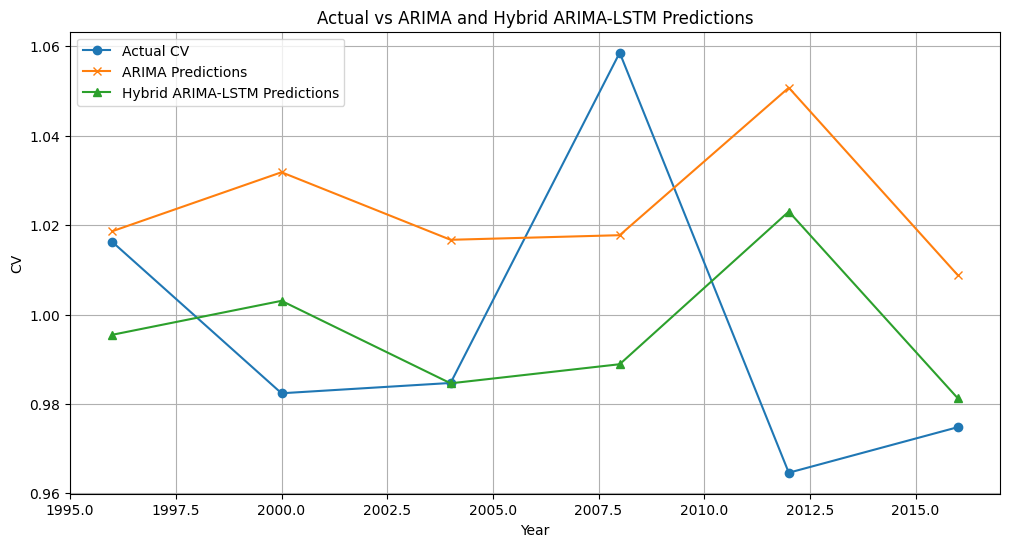

In [ ]:
import matplotlib.pyplot as plt

# Years for plotting
test_years = df.loc[test_indices, 'Year'].values

plt.figure(figsize=(12,6))
plt.plot(test_years, y_actual, label='Actual CV', marker='o')
plt.plot(test_years, arima_pred_test, label='ARIMA Predictions', marker='x')
plt.plot(test_years, final_pred, label='Hybrid ARIMA-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs ARIMA and Hybrid ARIMA-LSTM Predictions')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


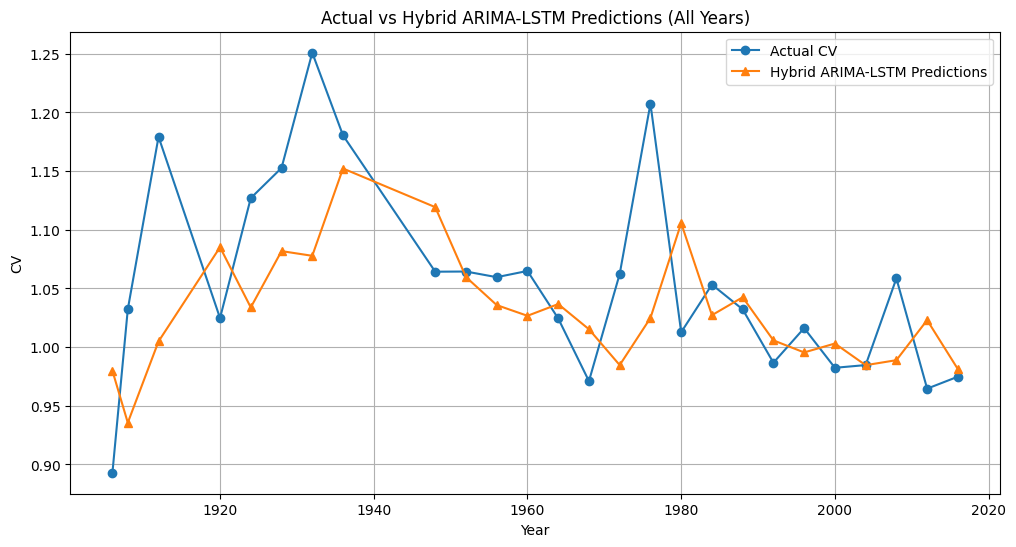

In [ ]:
# Step 1: Predict ARIMA values for all years in the DataFrame
arima_all_pred = model_arima_fit.predict(start=df.index[0], end=df.index[-1])

# Step 2: Prepare residuals for LSTM predictions (all years)
# Normalize ARIMA residuals for the entire dataset
df['CV_residual'] = df['CV'] - arima_all_pred
df['CV_residual'].fillna(method='bfill', inplace=True)
df['CV_residual_scaled'] = scaler.transform(df['CV_residual'].values.reshape(-1, 1))

# Create sequences for the entire dataset
data_all = df['CV_residual_scaled'].values
X_all, _ = create_sequences(data_all, window_size)

# Reshape input for LSTM
X_all = X_all.reshape((X_all.shape[0], window_size, 1))

# Step 3: Predict LSTM residuals for all sequences
lstm_all_residual_scaled = model_lstm.predict(X_all)

# Inverse scaling of residual predictions
lstm_all_residual = scaler.inverse_transform(lstm_all_residual_scaled)

# Step 4: Combine ARIMA predictions with LSTM residual predictions
# Extend ARIMA predictions to match the LSTM output
hybrid_all_pred = arima_all_pred[window_size:] + lstm_all_residual.flatten()

# Actual values (aligned with hybrid predictions)
actual_values = df['CV'].values[window_size:]

# Step 5: Plot actual vs. hybrid predictions
import matplotlib.pyplot as plt

# Get years corresponding to hybrid predictions
years = df['Year'].values[window_size:]

plt.figure(figsize=(12, 6))
plt.plot(years, actual_values, label='Actual CV', marker='o')
plt.plot(years, hybrid_all_pred, label='Hybrid ARIMA-LSTM Predictions', marker='^')
plt.xlabel('Year')
plt.ylabel('CV')
plt.title('Actual vs Hybrid ARIMA-LSTM Predictions (All Years)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
r2 = r2_score(actual_values, hybrid_all_pred)
print("R² value:", r2)

R² value: 0.09015289433008433
